In [20]:
import json
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, SubsetRandomSampler
from torchvision import models
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
import time
import albumentations as A
from collections import Counter

weather_dict_file = open('weather_dict.json','r')
weather_dict = json.load(weather_dict_file)
w_by_i = {int(i):key for i,key in weather_dict[0].items()}
i_by_w = {key:int(i) for key,i in weather_dict[1].items()}
train_folder = 'drivedata_v2/train'
test_folder = 'drivedata_v2/test_weather/'
my_ph_folder = 'my_ph/'
print(w_by_i)
if torch.cuda.is_available():
    device = torch.device('cuda:0')
print(torch.cuda.get_device_name(0))
#i_by_w['partly cloudy'] = 0
print(i_by_w)

{0: 'clear', 1: 'overcast', 2: 'rainy', 3: 'snowy', 4: 'foggy'}
GeForce RTX 2060
{'clear': 0, 'overcast': 1, 'rainy': 2, 'snowy': 3, 'foggy': 4}


In [2]:
class WeatherOnlyDataset(Dataset):
    def __init__(self, folder, transform=None):
        self.transform = transform
        self.folder = folder
        folder_names = os.listdir(self.folder)
        filenames = []
        for folder_name in folder_names:
            temp_filenames = os.listdir(os.path.join(folder,folder_name))
            temp_filenames = [os.path.join(folder,folder_name, file) for file in temp_filenames]
            filenames.extend(temp_filenames)
        self.filenames = [ [name, i_by_w[name.split('\\')[1]],name.split('\\')[2].replace('.jpg','')] for name in filenames]
        self.transform = transform
        
    def __len__(self):
        return len(self.filenames)
    
    def __getitem__(self, index):
    
        img = Image.open(str(self.filenames[index][0]))
        y = self.filenames[index][1]
        img_id = self.filenames[index][2]
        if self.transform: 
            img = self.transform(img)
        return img, y, img_id

In [5]:
def init_aug():
    augmentation_pipeline = A.Compose(
    [
        A.ShiftScaleRotate(rotate_limit=10),
        A.HorizontalFlip(p = 0.5), # apply horizontal flip to 50% of images
        A.OneOf(
            [
                # apply one of transforms to 50% of images
                A.RandomContrast(), # apply random contrast
                A.RandomGamma(), # apply random gamma
                A.RandomBrightness(), # apply random brightness
            ],
            p = 0.5
        ),
    ],
    p = 1
    )
    return augmentation_pipeline

In [4]:
def visualize_samples(dataset, indices, title=None, count=10):
    # visualize random 10 samples
    plt.figure(figsize=(count*3,3))
    display_indices = indices[:count]
    if title:
        plt.suptitle("%s %s/%s" % (title, len(display_indices), len(indices)))        
    for i, index in enumerate(display_indices): 
        x, y, _ = dataset[index]
        trans = transforms.ToPILImage()
        x = trans(x)
        plt.subplot(1,count,i+1)
        plt.title("Label: %s" % y)
        plt.imshow(x)
        plt.grid(False)
        plt.axis('off')   

In [35]:
orig_dataset = WeatherOnlyDataset('image2weather')

['image2weather\\clear\\100017842.jpg', 0, '100017842']


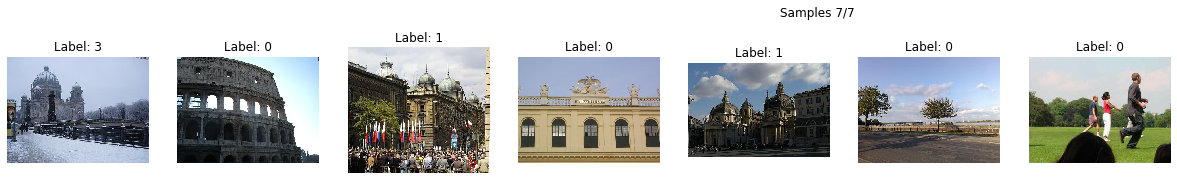

In [57]:
indices = np.random.choice(np.arange(len(orig_dataset)), 7, replace=False)
visualize_samples(orig_dataset, indices, "Samples")

In [5]:
train_dataset = WeatherOnlyDataset(train_folder, 
                       transform=transforms.Compose([
                           transforms.Resize((224, 224)),
                           transforms.ToTensor(),
                           # Use mean and std for pretrained models
                           # https://pytorch.org/docs/stable/torchvision/models.html
                           transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])                         
                       ])
                      )

NotADirectoryError: [WinError 267] Неверно задано имя папки: 'drivedata/train\\0_city street_clear.jpg'

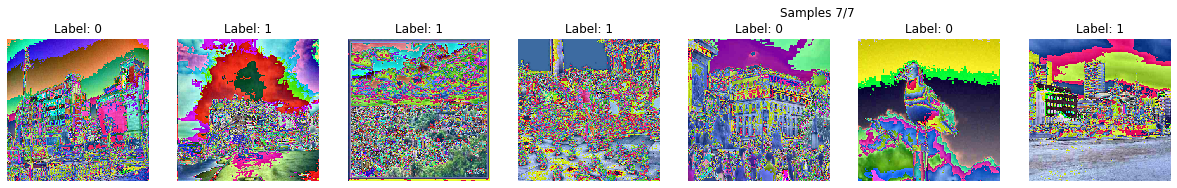

In [63]:
indices = np.random.choice(np.arange(len(orig_dataset)), 7, replace=False)
visualize_samples(train_dataset, indices, "Samples" )

In [74]:
batch_size = 16
data_size = len(orig_dataset)
validation_fraction = .1
val_split = int(np.floor((validation_fraction) * data_size))
indices = list(range(data_size))
np.random.seed(42)
np.random.shuffle(indices)
val_indices, train_indices = indices[:val_split], indices[val_split:]
train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                           sampler=train_sampler,pin_memory=True,num_workers=0)
val_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                         sampler=val_sampler,pin_memory=True)
#test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,pin_memory=True)


In [13]:
def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs):    
    loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        model.train() # Enter train mode
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        start = time.time()
        for i_step, (x, y,_) in enumerate(train_loader):
            start = time.time()
            x_gpu = x.to(device)
            y_gpu = y.to(device)
            
            prediction = model(x_gpu)    
            loss_value = loss(prediction, y_gpu)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y_gpu)
            total_samples += y.shape[0]
            
            loss_accum += loss_value
            print(i_step,  time.time()- start)
        ave_loss = loss_accum / i_step
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        
        print("Average loss: %f, Train accuracy: %f, Val balanced accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))
        
    return loss_history, train_history, val_history
        
def compute_accuracy(model, loader):
    """
    Computes accuracy on the dataset wrapped in a loader
    
    Returns: accuracy as a float value between 0 and 1
    """
    model.eval() # Evaluation mode
    pred = list()
    gr_tr = list()
    for (x,y,_) in loader:
        x = x.to(device=device)
        y = y.to(device=device)
        predict = model(x)
        x.cpu()
        _, indices = torch.max(predict, 1)
        gr_tr.extend(y.cpu().tolist())
        pred.extend(indices.cpu().tolist())
        
    val_accuracy = [gr_tr, pred]
    return val_accuracy

In [7]:
model = models.resnet18(pretrained=True)

In [70]:
num_ftrs = model.fc
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 5)
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [75]:
parameters = model.parameters()
loss = nn.CrossEntropyLoss()
optimizer = optim.SGD([{'params': model.fc.parameters(), 'lr': 1e-3},
                    {'params': list(model.parameters())[:-2]}],
                     lr=0.0001, momentum=0.9)
loss_history, train_history, val_history = train_model(model, train_loader, val_loader, loss, optimizer, 1)

0 2.6190528869628906
1 0.02792525291442871
2 0.024929285049438477
3 0.023935794830322266
4 0.024930715560913086
5 0.023936033248901367
6 0.024930238723754883
7 0.02393627166748047
8 0.023935794830322266
9 0.024932861328125
10 0.023935317993164062
11 0.023935556411743164
12 0.024928569793701172
13 0.025931119918823242
14 0.025931119918823242
15 0.024928808212280273
16 0.024933338165283203
17 0.025930166244506836
18 0.024933338165283203
19 0.023935794830322266
20 0.02592945098876953
21 0.024933576583862305
22 0.02492976188659668
23 0.023935556411743164
24 0.024932861328125
25 0.023935556411743164
26 0.024933338165283203
27 0.02393031120300293
28 0.02593064308166504
29 0.024932384490966797
30 0.0249326229095459
31 0.024928569793701172
32 0.024933338165283203
33 0.023933887481689453
34 0.025930166244506836
35 0.024933338165283203
36 0.026927709579467773
37 0.025930404663085938
38 0.024933576583862305
39 0.024928808212280273
40 0.024933338165283203
41 0.02492690086364746
42 0.02393603324890

338 0.023936033248901367
339 0.023935794830322266
340 0.0249326229095459
341 0.02293848991394043
342 0.023935794830322266
343 0.023931264877319336
344 0.023935794830322266
345 0.0249330997467041
346 0.023935794830322266
347 0.023935317993164062
348 0.023936033248901367
349 0.02393651008605957
350 0.023932456970214844
351 0.0249330997467041
352 0.024932861328125
353 0.023936033248901367
354 0.024932146072387695
355 0.023936033248901367
356 0.023935556411743164
357 0.023936033248901367
358 0.023935317993164062
359 0.023935556411743164
360 0.023936033248901367
361 0.023935794830322266
362 0.023936033248901367
363 0.023935556411743164
364 0.024928808212280273
365 0.023936033248901367
366 0.023935317993164062
367 0.023936033248901367
368 0.023935794830322266
369 0.023935794830322266
370 0.023936033248901367
371 0.02393651008605957
372 0.02393507957458496
373 0.023935556411743164
374 0.02393507957458496
375 0.02493119239807129
376 0.023935794830322266
377 0.024933338165283203
378 0.023934364

672 0.023936033248901367
673 0.023936033248901367
674 0.02493119239807129
675 0.024933338165283203
676 0.02393627166748047
677 0.024929523468017578
678 0.024933576583862305
679 0.024930953979492188
680 0.023936033248901367
681 0.02393627166748047
682 0.025930404663085938
683 0.02593064308166504
684 0.024933338165283203
685 0.025928020477294922
686 0.024932861328125
687 0.0249330997467041
688 0.023936033248901367
689 0.0249330997467041
690 0.024933338165283203
691 0.024930238723754883
692 0.02393627166748047
693 0.024932861328125
694 0.024933576583862305
695 0.023935794830322266
696 0.023936033248901367
697 0.023935794830322266
698 0.023934125900268555
699 0.023935317993164062
700 0.023936033248901367
701 0.02393651008605957
702 0.02493119239807129
703 0.023936033248901367
704 0.02393651008605957
705 0.023935794830322266
706 0.024930953979492188
707 0.024929046630859375
708 0.023936033248901367
709 0.023937225341796875
710 0.023935556411743164
711 0.023935317993164062
712 0.023936033248

1005 0.023930788040161133
1006 0.023935794830322266
1007 0.024927854537963867
1008 0.02393174171447754
1009 0.023935556411743164
1010 0.024929046630859375
1011 0.024931907653808594
1012 0.0249326229095459
1013 0.023935556411743164
1014 0.023935794830322266
1015 0.023932456970214844
1016 0.024927139282226562
1017 0.024929285049438477
1018 0.0249330997467041
1019 0.023935556411743164
1020 0.023935556411743164
1021 0.02393507957458496
1022 0.023936033248901367
1023 0.023935317993164062
1024 0.02393198013305664
1025 0.024932384490966797
1026 0.023935794830322266
1027 0.023935556411743164
1028 0.023935794830322266
1029 0.027926206588745117
1030 0.023934125900268555
1031 0.025929927825927734
1032 0.024929046630859375
1033 0.023936033248901367
1034 0.023935556411743164
1035 0.023936033248901367
1036 0.023936033248901367
1037 0.02492809295654297
1038 0.024928569793701172
1039 0.023936033248901367
1040 0.022938013076782227
1041 0.023935556411743164
1042 0.023935556411743164
1043 0.0239365100860

1325 0.023935794830322266
1326 0.024930953979492188
1327 0.023935556411743164
1328 0.02393507957458496
1329 0.023935794830322266
1330 0.026926755905151367
1331 0.023935794830322266
1332 0.024930953979492188
1333 0.023936033248901367
1334 0.023936033248901367
1335 0.02393317222595215
1336 0.023936033248901367
1337 0.024929523468017578
1338 0.023935556411743164
1339 0.02393054962158203
1340 0.02393507957458496
1341 0.023935794830322266
1342 0.02492809295654297
1343 0.024933576583862305
1344 0.023936033248901367
1345 0.02393031120300293
1346 0.023936033248901367
1347 0.02393627166748047
1348 0.023936033248901367
1349 0.024926185607910156
1350 0.023935556411743164
1351 0.024932861328125
1352 0.024933815002441406
1353 0.023931503295898438
1354 0.023936033248901367
1355 0.022938966751098633
1356 0.023936033248901367
1357 0.0249330997467041
1358 0.02492976188659668
1359 0.023935794830322266
1360 0.023935556411743164
1361 0.024933815002441406
1362 0.023935794830322266
1363 0.023935794830322266

KeyboardInterrupt: 

In [37]:
result_file = open('val_result_weather.json','r')
result = json.load(result_file)
pred = np.array(result[0])
gr_tr = np.array(result[1])
print(Counter(pred))

Counter({0: 4787, 1: 1406, 3: 692, 2: 491, 5: 401, 4: 11})


In [38]:
print(metrics.classification_report(gr_tr,pred,target_names=list(i_by_w.keys())))

               precision    recall  f1-score   support

        clear       0.91      0.93      0.92      4669
     overcast       0.70      0.87      0.78      1133
        rainy       0.79      0.66      0.72       594
        snowy       0.81      0.76      0.79       740
        foggy       0.36      0.13      0.20        30
partly cloudy       0.77      0.50      0.61       622

     accuracy                           0.85      7788
    macro avg       0.73      0.64      0.67      7788
 weighted avg       0.85      0.85      0.84      7788



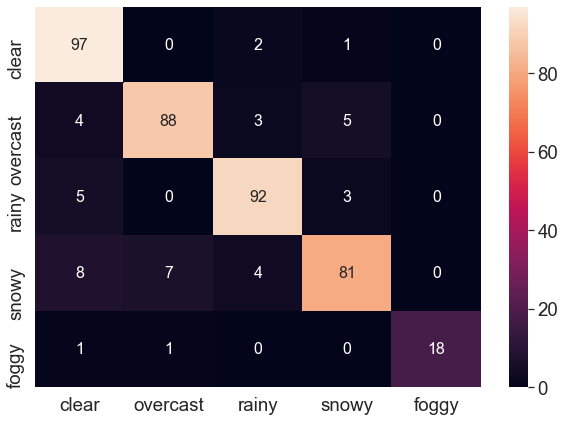

In [18]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

array = metrics.confusion_matrix(gr_tr,pred)

df_cm = pd.DataFrame(array, i_by_w.keys(), i_by_w.keys())
plt.figure(figsize=(10,7))
sn.set(font_scale=1.7) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size

plt.show()

## Другая папка

In [36]:
class WeatherDataset(Dataset):
    def __init__(self, folder, transform=None, augmentation=None):
        self.transform = transform
        self.augmentation=augmentation
        self.folder = folder
        filenames = os.listdir(self.folder)
        self.filenames = [name for name in filenames if name != 'desktop.ini' and name.split('_')[2]!='undefined.jpg']
        splited = [x.replace('.jpg','').split('_') for x in self.filenames]
        self.splited = [[i_by_w[x[2]],x[0]] for x in splited]
        self.transform = transform
        
    def __len__(self):
        return len(self.filenames)
    
    def __getitem__(self, index):
        img = Image.open(os.path.join(self.folder, self.filenames[index]))
        y = self.splited[index][0]
        img_id = self.splited[index][1]
        if self.augmentation:
            img = self.augmentation(image = np.array(img))['image']
        if self.transform: 
            img = self.transform(img)
        return img, y, self.filenames[index]

In [47]:
train_dataset = WeatherDataset(train_folder, 
                       transform=transforms.Compose([
                           transforms.Resize((224, 224)),
                           transforms.ToTensor(),
                           # Use mean and std for pretrained models
                           # https://pytorch.org/docs/stable/torchvision/models.html
                           transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])                         
                       ]),
                        augmentation=init_aug()
                      )
test_dataset =WeatherDataset(test_folder, 
                       transform=transforms.Compose([
                           transforms.Resize((224, 224)),
                           transforms.ToTensor(),
                           # Use mean and std for pretrained models
                           # https://pytorch.org/docs/stable/torchvision/models.html
                           transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])                         
                       ])
                      )
my_ph_dataset =WeatherDataset(my_ph_folder, 
                       transform=transforms.Compose([
                           transforms.Resize((224, 224)),
                           transforms.ToTensor(),
                           # Use mean and std for pretrained models
                           # https://pytorch.org/docs/stable/torchvision/models.html
                           transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])                         
                       ])
                      )

In [48]:
batch_size = 16
data_size = len(train_dataset)
validation_fraction = .1
val_split = int(np.floor((validation_fraction) * data_size))
indices = list(range(data_size))
np.random.seed(42)
np.random.shuffle(indices)
val_indices, train_indices = indices[:val_split], indices[val_split:]
train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                           sampler=train_sampler,pin_memory=True,num_workers=4)
val_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                         sampler=val_sampler,pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,pin_memory=True)
my_ph_loader = torch.utils.data.DataLoader(my_ph_dataset, batch_size=batch_size,pin_memory=True)


In [39]:
model = torch.load('weather_models_checkpoint/scene_2020-02-24_06-26_4_0.8801598084308191.pt')
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1

In [51]:
[gr_tr,pred] = compute_accuracy(model,test_loader)
#errors = compute_test_metrics(model, test_loader)

In [52]:
print(metrics.classification_report(gr_tr,pred,target_names=list(i_by_w.keys())))

              precision    recall  f1-score   support

       clear       0.84      0.97      0.90       100
    overcast       0.92      0.88      0.90       100
       rainy       0.91      0.92      0.92       100
       snowy       0.90      0.81      0.85       100
       foggy       1.00      0.90      0.95        20

    accuracy                           0.90       420
   macro avg       0.91      0.90      0.90       420
weighted avg       0.90      0.90      0.89       420



In [32]:
def compute_test_metrics(model,loader):
    model.eval() # Evaluation mode
    pred = list()
    gr_tr = list()
    images = []
    errors = []
    toPILL = transforms.ToPILImage()
    for (x,y,name) in loader:
        x = x.to(device=device)
        y = y.to(device=device)
        predict = model(x)
        _, indices = torch.max(predict, 1)
        y = y.cpu().tolist()
        indices = indices.cpu().tolist()
        gr_tr.extend(y)
        pred.extend(indices)
        errors_temp = [{'image':name[i],'gr_tr':w_by_i[y[i]],"pred":w_by_i[indices[i]]} for i in range(len(y)) if y[i]!=indices[i]]
        errors.extend(errors_temp)
    return errors

In [50]:
folder = 'drivedata_v2/test_weather/'
count = len(errors)
i = 0
for error in errors:
    i+=1
    img = Image.open(os.path.join(folder,error['image']))
    print('gr_tr: %s pred: %s'% (error['gr_tr'],error['pred']), end="\r")
    img.show()
    input()

gr_tr: snowy pred: clear
gr_tr: overcast pred: snowy
